### Bibliotecas

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# alterando defaults
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('rainbow')

### Coleta de dados

In [3]:
#Nomes das colunas
book_cols = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
rating_cols = ['userId','ISBN','bookRating']
user_cols = ['userId','location','age']

books = pd.read_csv('Dataset/Books.csv', sep=',', encoding='latin-1')
books.columns = book_cols

ratings = pd.read_csv('Dataset/Ratings.csv', sep=',', encoding='latin-1')
ratings.columns = rating_cols

users = pd.read_csv('Dataset/Users.csv', sep=',', encoding='latin-1')
users.columns = user_cols

In [4]:
books.head(2)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [5]:
ratings.head(2)

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5


In [6]:
users.head(2)

,userId,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


# Limpeza dos Dados

Usando o método [DataFrame.info()](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html) para verificar o número de valores nulos e os tipos de dados dos dados

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


A coluna yearOfPublication deve ser definida com dtype como int, verificando assim os valores exclusivos de yearOfPublication usando o método [Series.unique()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html)

In [8]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Podemos observar acima que alguns nomes de autores estão misturados nos dados do ano, como 'DK Publishing Inc' e 'Gallimard'. Verificando as linhas que têm 'DK Publishing Inc' como yearOfPublication usando o método [DataFrame.loc[]](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html)

In [9]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


Existem dois livros com entradas de ano erradas, portanto, iremos corrigi-los abaixo

In [10]:
books.loc[books.ISBN == '078946697X','imageUrlL'] = 'http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '078946697X','imageUrlM'] = 'http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '078946697X','imageUrlS'] = 'http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '078946697X','publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = '2000'
books.loc[books.ISBN == '078946697X','bookAuthor'] = 'Michael Teitelbaum'
books.loc[books.ISBN == '078946697X','bookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

In [11]:
books.loc[books.ISBN == '0789466953','imageUrlL'] = 'http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '0789466953','imageUrlM'] = 'http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '0789466953','imageUrlS'] = 'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '0789466953','publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = '2000'
books.loc[books.ISBN == '0789466953','bookAuthor'] = 'James Buckley'
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

Verificando as linhas que têm 'Gallimard' como yearOfPublication

In [12]:
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [13]:
books.loc[books.ISBN == '2070426769','imageUrlL'] = 'http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '2070426769','imageUrlM'] = 'http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '2070426769','imageUrlS'] = 'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '2070426769','publisher'] = 'Gallimard'
books.loc[books.ISBN == '2070426769','yearOfPublication'] = '2003'
books.loc[books.ISBN == '2070426769','bookAuthor'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

Armazenando URLs de imagens em DataFrame diferentes porque não precisamos delas agora

In [14]:
books_data = books[['ISBN', 'bookTitle','imageUrlS', 'imageUrlM', 'imageUrlL']]
books = books[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']]

Verificando as alterações no ano de publicação

In [15]:
books.loc[(books.ISBN == '2070426769') | (books.ISBN == '078946697X') | (books.ISBN == '0789466953'),: ]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


Convertendo dados do ano do tipo de objeto para numérico usando [pd.to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) e se ocorrer erro, substituindo-os por valores NAN

In [16]:
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce')

O valor 0 para o ano é inválido e, como este conjunto de dados foi publicado em 2004, presumi que os anos posteriores a 2006 seriam inválidos, mantendo alguma margem caso o conjunto de dados fosse atualizado posteriormente, definindo anos inválidos como NaN.

In [17]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.nan

Usando [Series.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) para preencher os valores NAN com o valor médio dos anos e, em seguida, converter o tipo de dados para int

In [18]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()),inplace=True)
convert_dict = {'yearOfPublication': np.int64,}
books = books.astype(convert_dict)

Verificando se há valores NULL presentes na coluna do publicador usando [Series.isnull()](https://pandas.pydata.org/docs/reference/api/pandas.Series.isnull.html)

In [19]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues

In [20]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


No clues for Tyrant Moon , Hence checking with rows having bookTitle as Finders Keepers to see if we can get any clues

In [21]:
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


No clues here either as every book has different publishers , So checking  with rows having author Elaine Corvidae and Linnea Sinclair

In [22]:
books.loc[(books.bookAuthor == 'Elaine Corvidae') | (books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Atribuindo os valores do publicador Null como 'Desconhecido'

In [23]:
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'Unknown'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'Unknown'

Checking for Null bookAuthor names 

In [24]:
books.loc[books.bookAuthor.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


Lets give the Null bookAuthor value as 'Unknown'

In [25]:
books.loc[(books.ISBN == '9627982032'),'bookAuthor'] = 'Unknown'

### Checando a Tabela de Usuários (Users)

Verificando valores ausentes e os tipos de dados das colunas

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId    278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Valores de idade abaixo de 4 e acima de 90 não fazem muito sentido para o projeto e, portanto, serão substituídos por NANs

In [27]:
users.loc[(users.age > 90) | (users.age < 4), 'age'] = np.nan

Substituindo NANs por valor médio de usuários e convertendo tipo de dados para int

Armazenando URLs de imagens em DataFrame diferentes porque não precisamos delas agora

In [28]:
users.age = users.age.fillna(users.age.mean())
users.age = users.age.astype(np.int64)

### Checando a Tabela de Avaliações (Ratings)

Avaliando valores ausentes e os tipos de dados das colunas

In [29]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Parece que não há valores NAN, então vamos dar uma olhada nos valores bookRating

In [30]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

bookRatings estão sempre entre 0-10, também o conjunto de dados de classificações terá n_users $\times$ n_books entradas se cada usuário classificou cada item,

In [31]:

n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

75670906880


Acima podemos dizer que o conjunto de dados é muito esparso, o conjunto de dados de classificações deve ter apenas livros que existem em nosso conjunto de dados de livros, a menos que novos livros sejam adicionados ao conjunto de dados de livros

In [32]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

O conjunto de dados de classificações também deve ter classificações de usuários que existem no conjunto de dados de usuários, a menos que novos usuários sejam adicionados ao conjunto de dados de usuários.

In [33]:
ratings_new = ratings_new[ratings_new.userId.isin(users.userId)]

Cálculo de [Esparsidade](https://campus.datacamp.com/courses/recommendation-engines-in-pyspark/recommending-movies?ex=3) dos dados

In [34]:
sparsity = 1 - (len(ratings_new)/(n_users*n_books))
print("Número de usuários = " + str(n_users) + ", Número de livros = " + str(n_books) 
      + "\nO banco de dados possui uma taxa de " + str(sparsity*100) + " % de Esparsidade")

Número de usuários = 278858, Número de livros = 271360
O banco de dados possui uma taxa de 99.99863734155898 % de Esparsidade


Criando dois novos dataframes de classificação onde classificações diferentes de 0 estão presentes e vice-versa

In [35]:
rating_explicit = ratings_new.loc[ratings_new.bookRating != 0, :]
rating_implicit = ratings_new.loc[ratings_new.bookRating == 0, :]
print("Formato de dados de classificações explícitas = " + str(rating_explicit.shape) + "\nFormato de dados de classificações implícitas = " + str(rating_implicit.shape))

Formato de dados de classificações explícitas = (383842, 3)
Formato de dados de classificações implícitas = (647294, 3)


### Visualising Explicit Rating Counts

Using [Seaborn](https://towardsdatascience.com/seaborn-python-8563c3d0ad41) Library for ploting a [countplot](https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/)

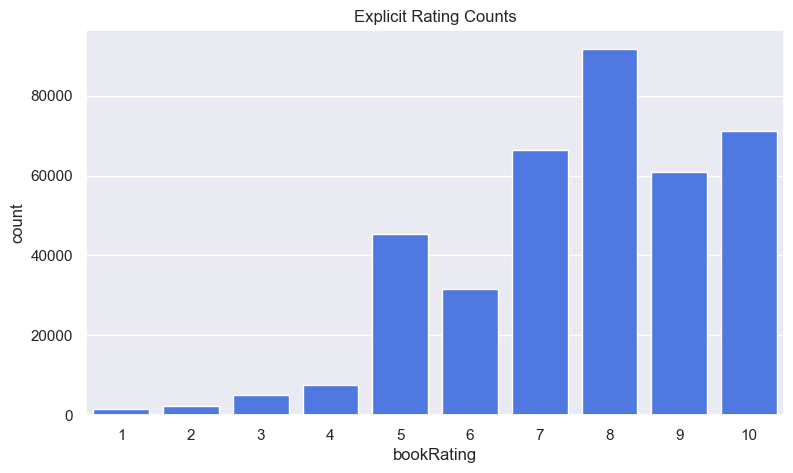

In [36]:
plt.figure(figsize=(9, 5))
plt.title('Explicit Rating Counts')
sns.countplot(x = 'bookRating', data = rating_explicit);

### Cleaning Title text

Function for cleaning title text using [Regex](https://en.wikipedia.org/wiki/Regular_expression) Library

In [37]:
def clean_text(text):
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text) 
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    
    #remove newline char
    text = re.sub('\n', '', text)
    
    return text

Applying clean_text() function on bookTitle column

In [38]:
books.bookTitle = books.bookTitle.apply(lambda x:clean_text(x))

Fazendo o merge de dados de livros e classificações usando [pd.merge()](https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/)

In [39]:
merged_data = pd.merge(books, ratings_new, on='ISBN')
merged_data =  merged_data.sort_values('ISBN', ascending=True)
merged_data.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating
1013651,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8
968138,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,86123,0
968139,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,209516,0
542150,0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,23902,9
788100,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,196149,0


In [40]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271359 non-null  object
 3   yearOfPublication  271360 non-null  int64 
 4   publisher          271360 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userId    278858 non-null  int64 
 1   location  278858 non-null  object
 2   age       278858 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.4+ MB


In [42]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


# 3. Análise Exploratória dos Dados

### Visualizando os 30 livros mais lidos

Usando [Series.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) e [sns.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) para criar dados e visualização, respectivamente

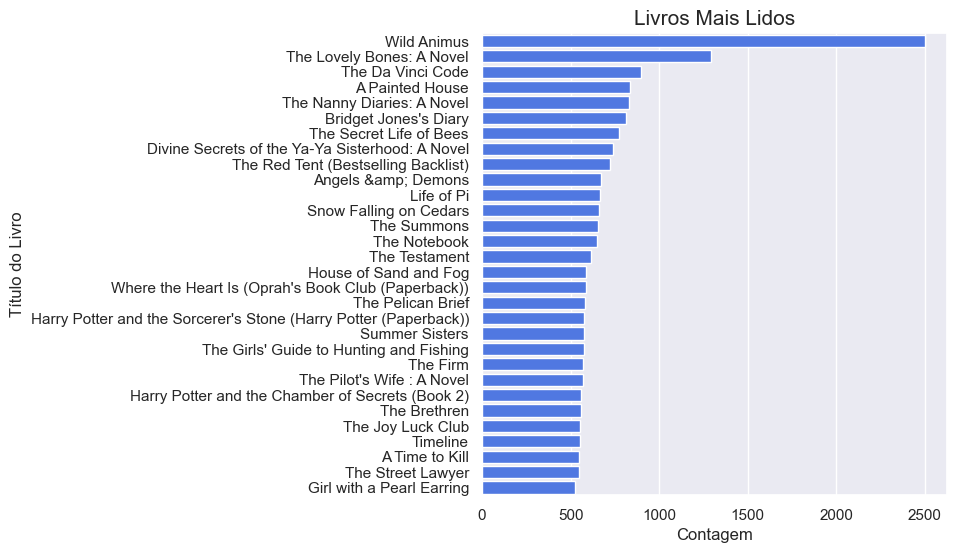

In [43]:
most_read = merged_data.bookTitle.value_counts().reset_index()
most_read.columns = ['bookTitle','count']

plt.figure(figsize = (6,6))
plt.title("Livros Mais Lidos", fontsize=15)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Título do Livro', fontsize=12)
sns.barplot(x = 'count', y = 'bookTitle', data = most_read.head(30));

### Livros mais bem avaliados (classificação média de acordo com o número de usuários)

In [44]:
top_rated = merged_data[['bookTitle','bookRating']]
top_rated = top_rated.groupby('bookTitle', as_index=False)['bookRating'].mean()
top_rated = top_rated.sort_values('bookRating',ascending=False).reset_index()
top_rated = top_rated[['bookTitle','bookRating']]

top_rated.head()

,bookTitle,bookRating
0,Timelock: How Life Got So Hectic and What You ...,10.0
1,Timelines of World History,10.0
2,Bathroom Game Book,10.0
3,"Rookie Princess (Silhouette Desire, No 483)",10.0
4,Roof World,10.0


In [45]:
top_rated.tail()

,bookTitle,bookRating
241066,name the baby.,0.0
241067,namedropping.,0.0
241068,net future,0.0
241069,'Twas the Night Before Christmas,0.0
241070,Harry Potter and the Bible: The Menace Behind...,0.0


### Visualizando os 30 livros mais lidos com suas classificações médias

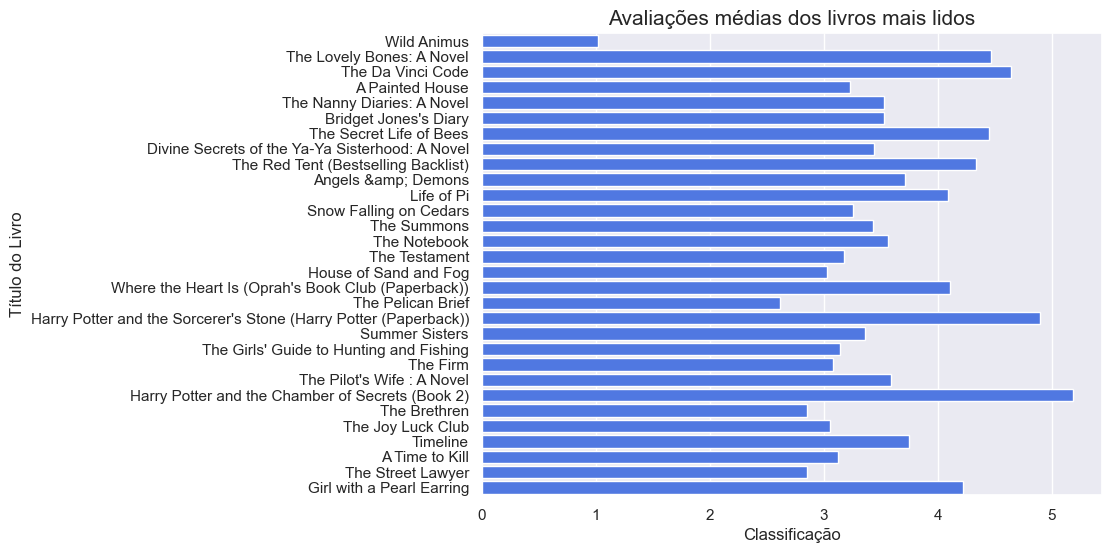

In [46]:
avg_data = merged_data.groupby('bookTitle', as_index=False)['bookRating'].mean()
temp = merged_data.bookTitle.value_counts().reset_index()
temp.columns = ['bookTitle','count']
most_rated_by_reads = pd.merge(avg_data,temp,on='bookTitle')

most_rated_by_reads = most_rated_by_reads.sort_values('count',ascending=False)

plt.figure(figsize=(8,6))
plt.title("Avaliações médias dos livros mais lidos", fontsize=15)
plt.xlabel('Classificação', fontsize=12)
plt.ylabel('Título do Livro', fontsize=12)
sns.barplot(x = 'bookRating', y = 'bookTitle', data = most_rated_by_reads.head(30));

### Visualising Count of Books with a specific length

Creating title_length data for every title in bookTitle column and ploting a histplot

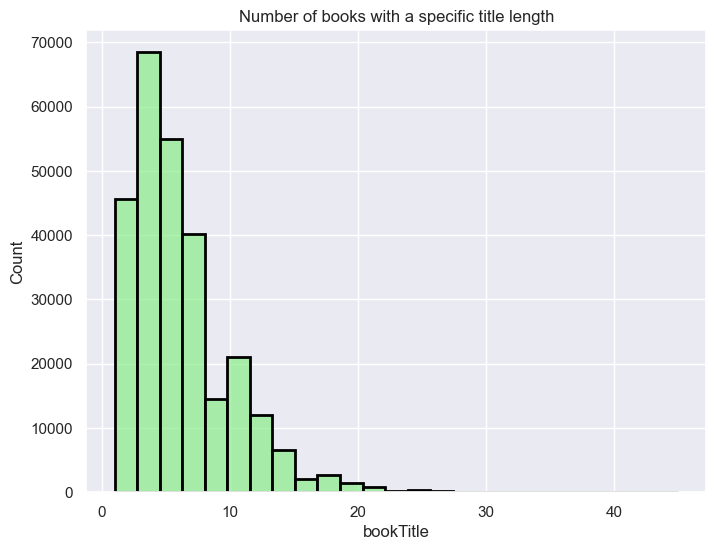

In [47]:
title_length = books.bookTitle.str.split().map(lambda x: len(x))
plt.figure(figsize=(8,6))
plt.title('Number of books with a specific title length')
sns.histplot(title_length, bins=25, color = 'lightgreen', linewidth = 2, edgecolor = 'black');

### Visualizando os 30 anos com mais livros publicados

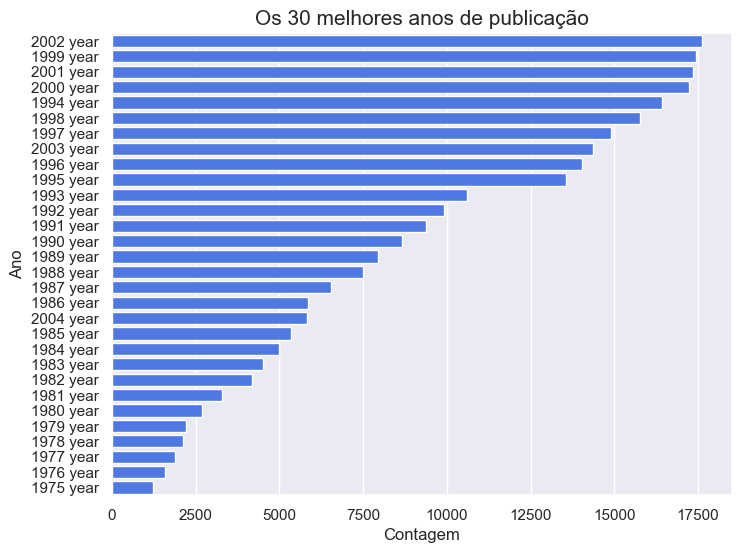

In [48]:
yearOP = books['yearOfPublication'].value_counts().reset_index()
yearOP.columns = ['value', 'count']
yearOP['year'] = yearOP['value'].astype(str) + ' year'
yearOP = yearOP.sort_values('count',ascending=False)

plt.figure(figsize=(8,6))
plt.title('Os 30 melhores anos de publicação', fontsize=15)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Ano', fontsize=12)
sns.barplot(data = yearOP.head(30), x='count', y="year");

### Visualizando os 30 principais autores com mais livros

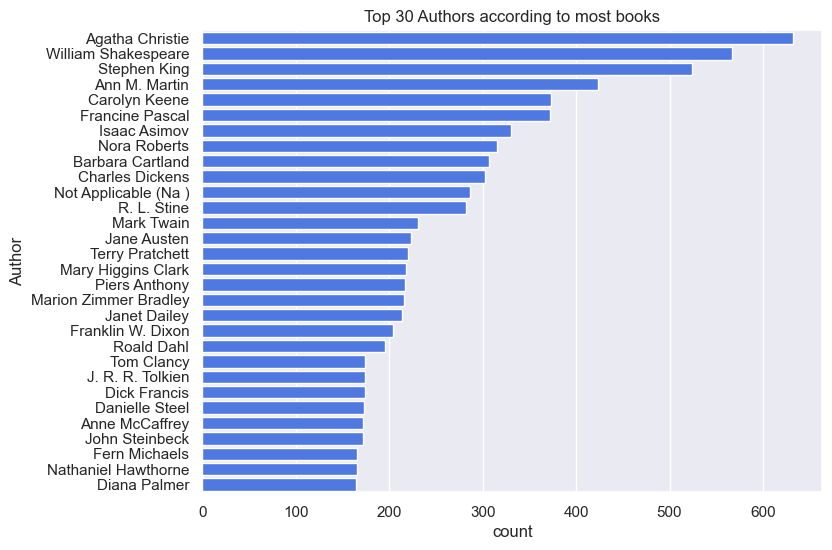

In [49]:
top_author = books['bookAuthor'].value_counts().reset_index()
top_author.columns = ['Author', 'count']
top_author['Author'] = top_author['Author']
top_author = top_author.sort_values('count',ascending=False)

plt.figure(figsize=(8,6))
plt.title('Top 30 Authors according to most books')
sns.barplot(data = top_author.head(30), x = 'count', y = 'Author');

### Visualizando as 30 principais editoras com o maior número de livros

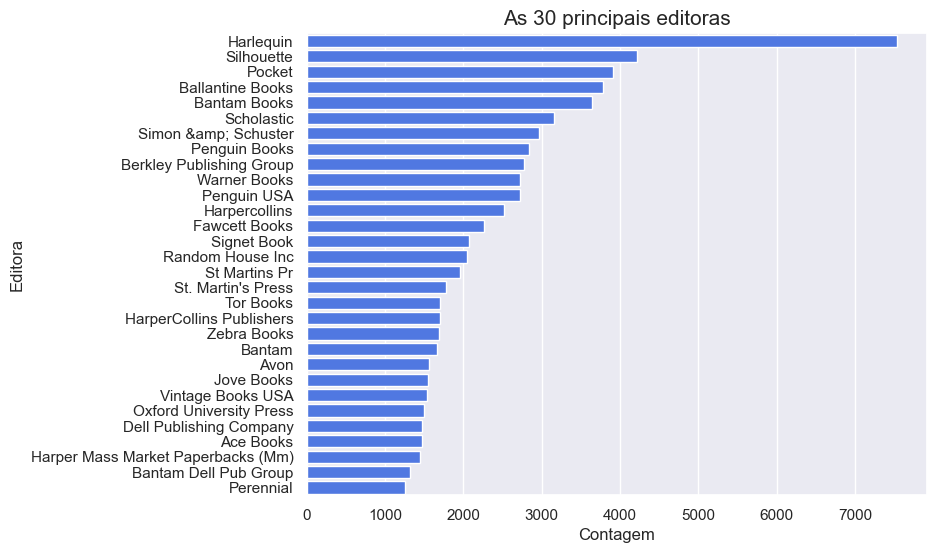

In [50]:
top_publisher = books['publisher'].value_counts().reset_index()
top_publisher.columns = ['Publisher', 'count']
top_publisher['Publisher'] = top_publisher['Publisher']
top_publisher = top_publisher.sort_values('count',ascending=False)

plt.figure(figsize=(8,6))
plt.title('As 30 principais editoras', fontsize=15)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Editora', fontsize=12)
sns.barplot(data = top_publisher.head(30), x = 'count', y = 'Publisher');

### Visualizando a distribuição etária dos usuários

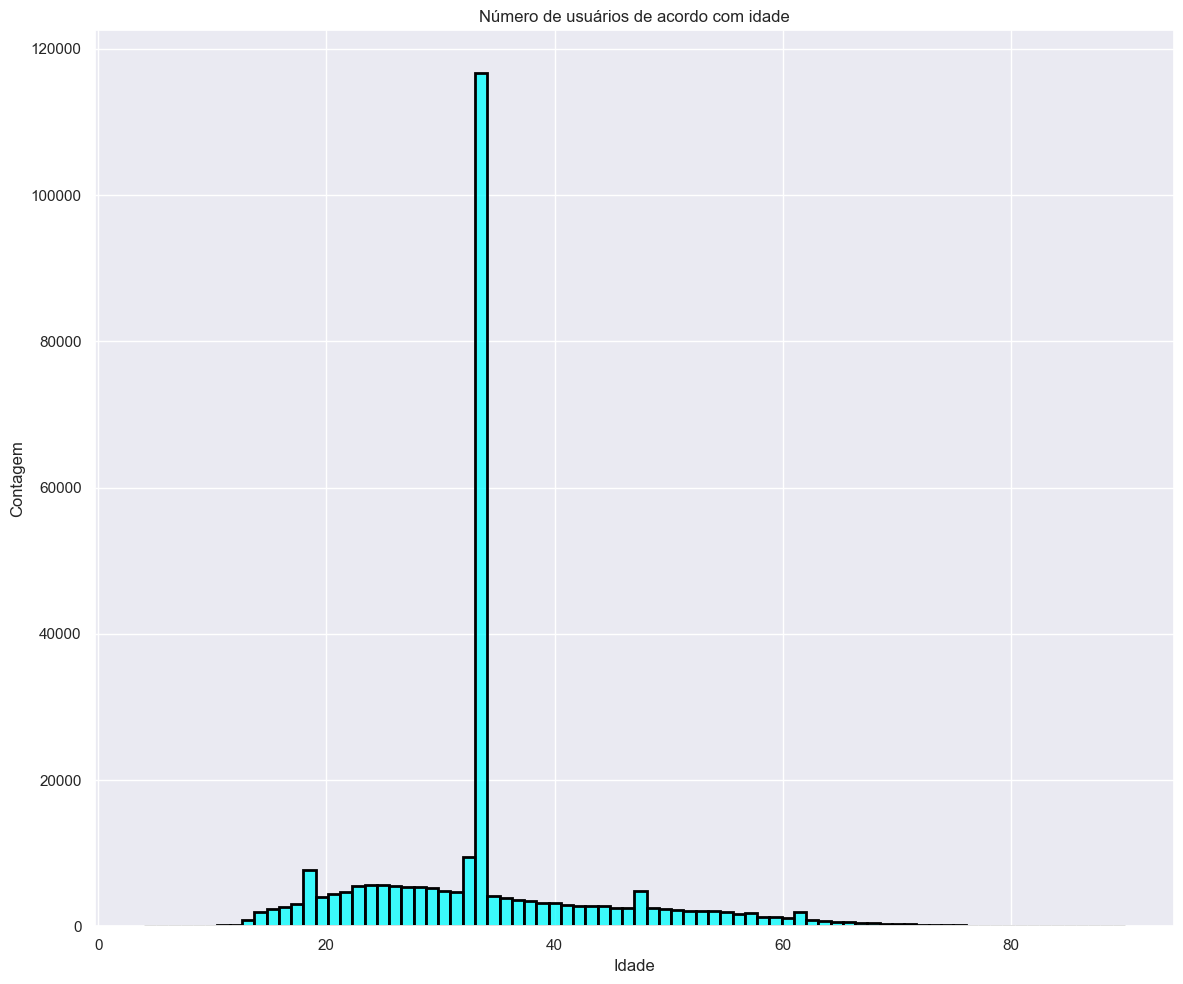

In [51]:
user_age = users.age
plt.figure(figsize=(12,10), tight_layout=True)
plt.title('Número de usuários de acordo com idade', fontsize=12)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
sns.histplot(user_age, bins=80, linewidth = 2, color = 'cyan', edgecolor = 'black');

### Visualising most frequent words in Author, Title and Publisher string

Creating string variables for bookAuthor, bookTitle and publisher, also creating a function to plot [WordCloud()](https://www.geeksforgeeks.org/generating-word-cloud-python/) 

In [52]:
author_string = " ".join(books['bookAuthor'].astype(str))
title_string = " ".join(books['bookTitle'].astype(str))
publisher_string = " ".join(books['publisher'].astype(str))
stop_words = set(STOPWORDS)

def wordcloud(string,title ="unknown"):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21,
                   stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.title(title)
    plt.axis('off')
    plt.imshow(wc)

Displaying most frequent words in author names

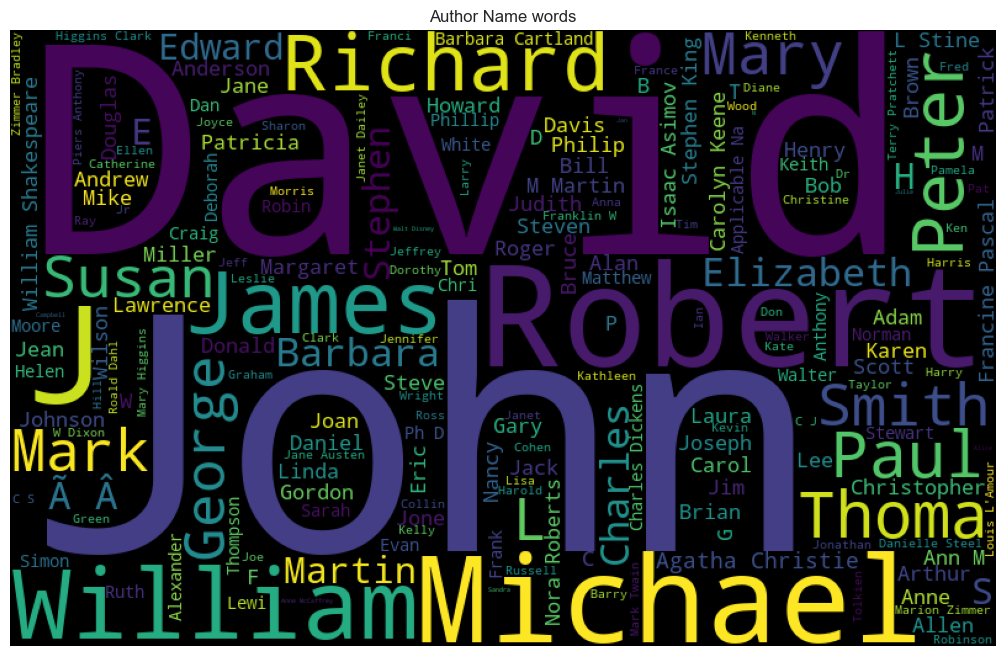

In [53]:
wordcloud(author_string,'Author Name words')

Displaying most frequent words in title text

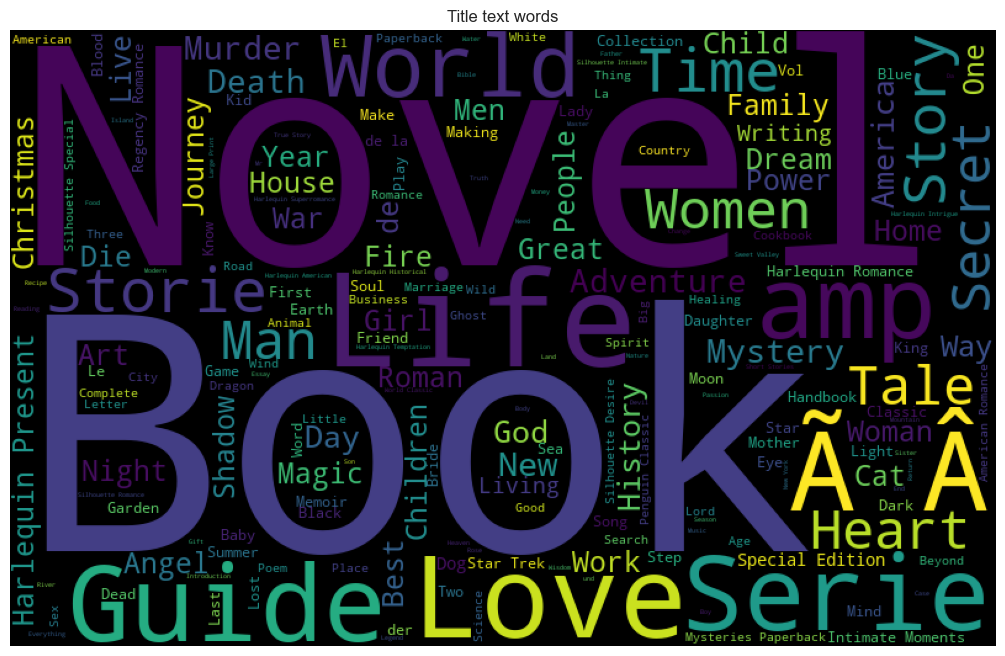

In [54]:
wordcloud(title_string,'Title text words')

Displaying most frequent words in publisher names

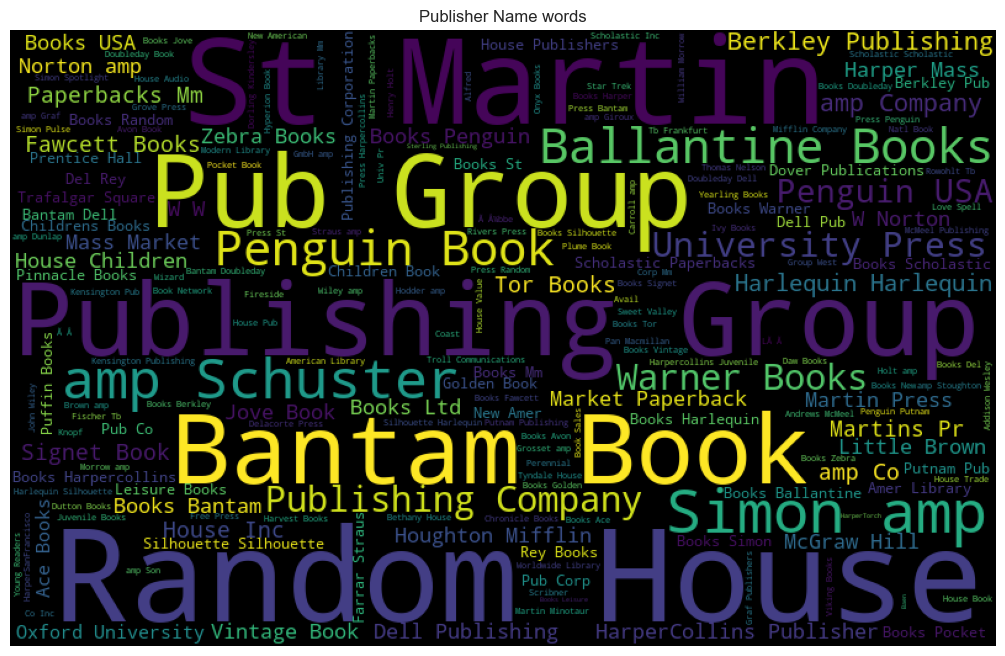

In [55]:
wordcloud(publisher_string,'Publisher Name words')

# 4. Popularity Based Recommendation

Below we show top 10 recommendations based on popularity using sum of bookRating values to choose which is popular.    
It is evident that books authored by [J.K. Rowling](https://www.jkrowling.com/) are one of the most popular

In [56]:
ratings_count = pd.DataFrame(rating_explicit.groupby(['ISBN'])['bookRating'].sum())
top_10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print("Following books are recommended")
top_10.merge(books, left_index = True, right_on = 'ISBN').reset_index()

Following books are recommended


,index,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
2,522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
3,2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
4,356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
5,26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
6,1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
7,706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
8,231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
9,118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


# 5. Data Preprocessing

Users with less than 100 ratings, and books with less than 100 ratings are excluded

In [57]:
counts1 = ratings_new['userId'].value_counts()
ratings_data = ratings_new[ratings_new['userId'].isin(counts1[counts1 >= 100].index)]
counts = ratings_data['bookRating'].value_counts()
ratings_data = ratings_data[ratings_data['bookRating'].isin(counts[counts >= 100].index)]

With the new ratings data we merge the Books data using pd.merge() and drop irrelavant columns

In [58]:
merged_new = pd.merge(ratings_data,books,on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor']
merged_new = merged_new.drop(columns, axis=1)

Creating a DataFrame number_rating with count of number of times a book is being rated   
[Using DataFrame.rename()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html) to rename columns

In [59]:
number_rating = merged_new.groupby('bookTitle')['bookRating'].count().reset_index()
number_rating.rename(columns={'bookRating':'number of rating'},inplace=True)
number_rating.head()

,bookTitle,number of rating
0,A Light in the Storm: The Civil War Diary of ...,3
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


Creating final_ratings DataFrame for every bookTitle with bookRatings and number of ratings

In [60]:
final_ratings = merged_new.merge(number_rating,on='bookTitle') 
final_ratings.head()

,userId,ISBN,bookRating,bookTitle,number of rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,101
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7
2,277427,003008685X,8,Pioneers,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),17


We consider those book who have been rated more than 30 times

In [61]:
final_ratings = final_ratings[final_ratings['number of rating']>=30] 

Droping duplicate records from final_ratings using [DataFrame.drop_duplicates()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) and checking the change of DataFrame size

In [62]:
print("Shape Before :" + str(final_ratings.shape))
final_ratings.drop_duplicates(['userId','bookTitle'],inplace=True)
print("Shape After  :" + str(final_ratings.shape))

Shape Before :(145111, 5)
Shape After  :(142011, 5)


Creating  a pivot table for final_ratings dataframe with columns as userId and index as bookTitle with values as bookRatings with the help of [DataFrame.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html)

In [63]:
book_pivot = final_ratings.pivot_table(columns='userId',index='bookTitle',values='bookRating')
book_pivot.shape

(2324, 1652)

Filling the NAN values with zeros

In [64]:
book_pivot.fillna(0,inplace=True)
book_pivot

userId,254,507,882,1424,1435,1733,1903,2033,2110,2276,...,275020,275970,276463,276680,277427,277478,277639,278137,278188,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Belong to Me and Other True Cases (Ann Rule's Crime Files: Vol. 2),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zlata's Diary: A Child's Life in Sarajevo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Machine Learning Modelling and Output

Using [scipy](https://www.scipy.org/) library's [compressed sparse row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) to create sparse book matrix with book_pivot as input   
We then use this sparse matrix to provide an input to the scikit-learn's [NearestNeighbors model](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) with [brute algorithm](https://www.kdnuggets.com/2020/10/exploring-brute-force-nearest-neighbors-algorithm.html) and [metric cosine](https://www.machinelearningplus.com/nlp/cosine-similarity/).

In [65]:
book_sparse=csr_matrix(book_pivot)
model=NearestNeighbors(metric='cosine',algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

Creating a function which will recommend 10 new books for the book you read according to the suggestions provided the model

In [66]:
def recommend(book_name):
    book_id = np.where(book_pivot.index==book_name)[0][0]
    distances,suggestions=model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1),n_neighbors = 11)
    
    
    books=[]
    for i in range(len(suggestions)):
        if i==0:
            print("The suggestions for ",book_name,"are : ")
        if not i:
            books = book_pivot.index[suggestions[i]]
    for i in range(1,len(books)):
         print(str(i) + ": " + books[i] )       
                
            
recommend('The Sum of All Fears (Jack Ryan Novels)')

The suggestions for  The Sum of All Fears (Jack Ryan Novels) are : 
1: Executive Orders (Jack Ryan Novels)
2: Clear and Present Danger (Jack Ryan Novels)
3: The Road to Omaha
4: Debt of Honor (Jack Ryan Novels)
5: Ruthless.Com (Tom Clancy's Power Plays (Paperback))
6: Without Remorse
7: Critical Mass
8: The Charm School
9: Fault Lines
10: The Postman (Bantam Classics)


# 7. Saving Files

In [67]:
import pickle
import joblib
from scipy.sparse import csr_matrix

# Salvar o modelo treinado
joblib.dump(model, 'modelo_knn.pkl')

# Salvar o DataFrame book_pivot
with open('book_pivot.pkl', 'wb') as f:
    pickle.dump(book_pivot, f)

print("Modelo e dados salvos com sucesso!")


Modelo e dados salvos com sucesso!
